### Imports (in Collab)

In [1]:
!pip install datasets --q
!pip install py7zr --q
!pip install evaluate --q
!pip install rouge_score --q
!pip install pyarrow==15.0.2 --q

In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from datasets import load_dataset
import evaluate
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('max_colwidth', None)

In [8]:
model_checkpoint = 'sshleifer/distill-pegasus-cnn-16-4'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).cuda()
model

/home/tgniazdo/miniconda3/envs/ner/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_no

In [3]:
dataset = load_dataset('samsum')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [4]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'dialogue': Value(dtype='string', id=None),
 'summary': Value(dtype='string', id=None)}

### Tokenize dataset

In [5]:
def tokenize_batch_dialogue(batch, tokenizer=tokenizer):
    return tokenizer(batch['dialogue'], truncation=True, padding=True, max_length=512)

def tokenize_batch_label(batch, tokenizer=tokenizer):
    with tokenizer.as_target_tokenizer():
        label = tokenizer(batch['summary'], truncation=True, padding=True, max_length=128).input_ids
    return {'labels': label}

In [7]:
dataset = dataset.map(tokenize_batch_dialogue, batched=True, batch_size=None)
dataset = dataset.map(tokenize_batch_label, batched=True, batch_size=None)
dataset

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [9]:
dataset.set_format('pandas')
df_train = dataset['train'][:]
df_train.head()

,id,dialogue,summary,input_ids,attention_mask,labels
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.,"[12195, 151, 125, 7091, 3659, 107, 842, 119, 245, 181, 152, 10508, 151, 7435, 147, 12195, 151, 125, 131, 267, 650, 119, 3469, 29344, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.,"[18038, 151, 2632, 127, 119, 6228, 118, 115, 136, 2974, 152, 10463, 151, 35884, 130, 329, 107, 18038, 151, 2587, 314, 1242, 10463, 151, 1509, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[18038, 111, 34296, 127, 6228, 118, 33195, 115, 136, 2974, 107, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",Kim may try the pomodoro technique recommended by Tim to get more stuff done.,"[4776, 151, 4451, 108, 180, 131, 116, 164, 152, 5377, 151, 6843, 4301, 83678, 108, 125, 140, 313, 112, 171, 1425, 113, 1549, 155, 2371, 164, 64428, 4776, 151, 463, 368, 119, 511, 124, 557, 152, 5377, 151, 4384, 119, 235, 108, 18857, 1549, 111, 1596, 2073, 56616, 161, 418, 5377, 151, 3183, 3469, 125, 131, 267, 696, 161, 130, 116, 111, 171, 579, 5377, 151, 184, 195, 313, 112, 38244, 114, 5713, 167, 1088, 113, 1553, 125, 131, 267, 1461, 181, 38244, 316, 9609, 4776, 151, 321, 557, 1549, 125, 1253, 881, 93882, 3111, 241, 4911, 207, 5033, 118, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[5377, 218, 508, 109, 891, 93882, 3111, 2087, 141, 4776, 112, 179, 154, 1549, 479, 107, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
def count_non_zero_ids(token_ids):
    return len([token_id for token_id in token_ids if token_id != 0])

df_train['len_input_ids'] = df_train['input_ids'].apply(lambda input_ids: count_non_zero_ids(input_ids))
df_train['len_labels'] = df_train['labels'].apply(lambda label: count_non_zero_ids(label))

### Number of tokens per sample

Text(0.5, 1.0, 'Lenght diffrence between dialogue and summary')

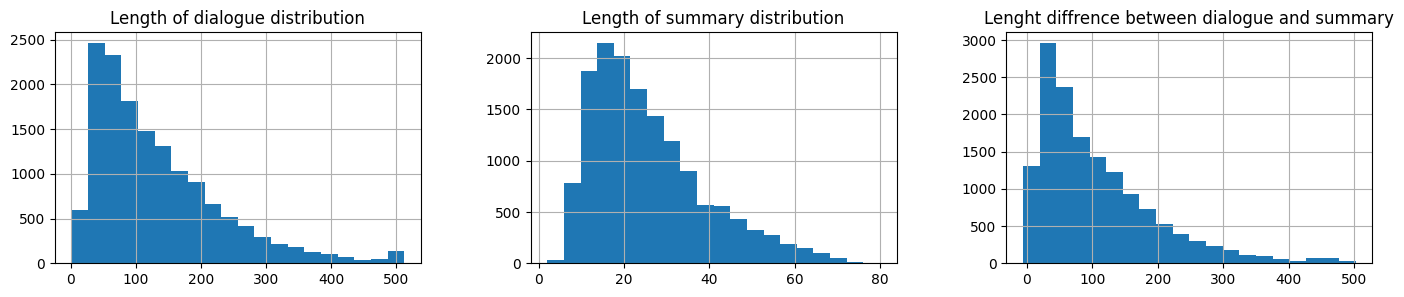

In [11]:
f, axs = plt.subplots(1, 3, figsize=(17, 3))
axs = axs.flatten()

df_train.hist(column=['len_input_ids'], bins=20, ax=axs[0])
axs[0].set_title('Length of dialogue distribution')

df_train.hist(column=['len_labels'], bins=20, ax=axs[1])
axs[1].set_title('Length of summary distribution')

df_train['len_diff'] = df_train.apply(lambda row: row['len_input_ids'] - row['len_labels'], axis=1)
df_train.hist(column=['len_diff'], bins=20, ax=axs[2])
axs[2].set_title('Lenght diffrence between dialogue and summary')

In [12]:
dataset['train'][0]

,id,dialogue,summary,input_ids,attention_mask,labels
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.,"[12195, 151, 125, 7091, 3659, 107, 842, 119, 245, 181, 152, 10508, 151, 7435, 147, 12195, 151, 125, 131, 267, 650, 119, 3469, 29344, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [13]:
dataset['train'][1]

,id,dialogue,summary,input_ids,attention_mask,labels
0,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.,"[18038, 151, 2632, 127, 119, 6228, 118, 115, 136, 2974, 152, 10463, 151, 35884, 130, 329, 107, 18038, 151, 2587, 314, 1242, 10463, 151, 1509, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[18038, 111, 34296, 127, 6228, 118, 33195, 115, 136, 2974, 107, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [14]:
dataset = dataset.remove_columns(['id', 'dialogue', 'summary'])
dataset.set_format('pytorch')
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

### Model finetuning

In [15]:
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

def compute_metrics(pred):
    labels = tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    predictions = tokenizer.batch_decode(pred.predictions[0].argmax(-1), skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return {
        'rouge1': rouge.compute(predictions=predictions, references=labels)['rouge1'],
        'rouge2': rouge.compute(predictions=predictions, references=labels)['rouge2'],
        'rougeL': rouge.compute(predictions=predictions, references=labels)['rougeL'],
        'bleu': bleu.compute(predictions=predictions, references=[[x] for x in labels])['bleu']
        }

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [17]:
training_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=1e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    evaluation_strategy='epoch',
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset['train'].shuffle(seed=6).select(range(3000)),
    eval_dataset=dataset['validation'].shuffle(seed=6).select(range(100)),
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu
0,No log,0.780307,0.549119,0.270066,0.500101,0.177107
2,2.336300,0.667373,0.582366,0.302739,0.542221,0.211487


TrainOutput(global_step=561, training_loss=2.1534590151645707, metrics={'train_runtime': 632.2822, 'train_samples_per_second': 14.234, 'train_steps_per_second': 0.887, 'total_flos': 7410044261892096.0, 'train_loss': 2.1534590151645707, 'epoch': 2.992})

In [19]:
trainer.evaluate()

{'eval_loss': 0.6673731803894043,
 'eval_rouge1': 0.5823658551142668,
 'eval_rouge2': 0.30273897015550993,
 'eval_rougeL': 0.5422210918985276,
 'eval_bleu': 0.21148667608076888,
 'eval_runtime': 3.7946,
 'eval_samples_per_second': 26.353,
 'eval_steps_per_second': 26.353,
 'epoch': 2.992}

### My example

In [20]:
def summarize_text(text, model, tokenizer):
    input = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt').to('cuda')
    output = model.generate(**input, do_sample=True, temperature=0.3, top_p=0.8, top_k=100)
    return tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [21]:
article = """British tech tycoon Mike Lynch and his 18-year-old daughter are among six people feared dead after
his 180ft superyacht Bayesian was hit by a freak waterspout and sank off the coast of Sicily this morning.
The luxury sailboat was docked off the coast of Porticello, near Palermo, when a waterspout struck the area just before 5am, wrecking the boat and causing it to rapidly disappear beneath the waves.
'The boat was all lit up. Around 4.30 am, it was no longer there,' said one witness cited by ANSA. 'A beautiful boat where there was a party. A normal joyous vacation day at sea turned into tragedy'.
Mr Lynch's wife Angela Bacares, 57, was among the fifteen people who were rescued from the 180ft yacht, which she is reported to have owned and had been carrying ten crewmembers, the owner and 11 guests.
Mrs Bacares told Italian media that both her husband and their daughter Hannah, 18, are missing after the yacht sank.
Mr Lynch had invited guests from legal firm Clifford Chance as well as his own company Invoke Capital to celebrate him being acquitted of fraud charges in June, vindicating the entrepreneur after a 12-year legal battle over the £8.6billion sale of his firm, Autonomy, to Hewlett-Packard in 2011, the Telegraph reports.
One of the Clifford Chance lawyers on board the Bayesian when it sank was 36-year-old Ayla Ronald. Her father, Lin Ronald, confirmed that the sailing trip was supposed to be a celebration of Mr Lynch's acquittal.
'I have texted with my daughter and she hasn't given me any updates about missing personnel or saved personnel. She has only said to me that there are deaths, and she and her partner are alive,' Mr Donald told the Telegraph. "
"""
article_summarized = summarize_text(
    text=article,
    model=trainer.model,
    tokenizer=tokenizer
)
print(article_summarized[0])

Mike Lynch's 180ft yacht was hit by a waterspout and sank off the coast of Porticello, near Palermo, at 4.30 am. His wife Angela Bacares, 57, was among the fifteen people rescued from the 180ft yacht. The yacht had been celebrating Mr Lynch's acquittal in June.
